#Mini Projeto: Classificar Dígitos


## Alunas:
## Maria Marcolina Lima Cardoso
## Paloma Duarte de Lira



In [134]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import random

from sklearn.preprocessing import scale
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from numpy import linalg as LA

from itertools import permutations

import warnings
warnings.filterwarnings("error")

In [135]:
trainset = pd.read_csv("train.csv", sep=';')
testset = pd.read_csv("test.csv", sep=';')


## Calculando a Intensidade e Simetria

In [136]:
def LerExcel(arq):
    # Retorna a lista já com as dimensões reduzidas -> posição 0 = label, posição 1 = intensidade, posição 2 = simetria
    # A intensidade e simetria são normalizadas

    vetorCompleto = pd.read_csv(arq, sep=';')
    vetorCompleto = vetorCompleto.values

    # Dimensão reduzida: Label, Intensidade, Simetria Vertical + Simetria Horizontal
    dim_reduzida = []

    for amostra in vetorCompleto:
        label = amostra[0]
        pixels = amostra[1:]

        # Intensidade
        intensidade_img = sum(pixels) / 255

        # Simetria Vertical
        simetria_v = 0
        for i in range(28):
            simetria_v += abs(pixels[i] - pixels[27 - i])
        simetria_v /= 13 * 255  # Normalização

        # Simetria Horizontal
        simetria_h = 0
        for i in range(14):
            for j in range(28):
                simetria_h += abs(pixels[i * 28 + j] - pixels[(27 - i) * 28 + j])
        simetria_h /= 13 * 28 * 255  # Normalização

        dim_reduzida.append([label, intensidade_img, simetria_v + simetria_h])

    # Convertendo para um array numpy
    dim_reduzida = np.array(dim_reduzida)

    # Aplicando Padronização (Standardization)
    dim_reduzida[:,1:] = (dim_reduzida[:,1:] - dim_reduzida[:,1:].mean(axis=0)) / dim_reduzida[:,1:].std(axis=0)

    return dim_reduzida


def IntensidadeXSimetria(t):
    t = np.array(t)
    plt.scatter(t[:,1], t[:,2], c=t[:,0], cmap='viridis')
    plt.xlabel('Intensidade')
    plt.ylabel('Simetria')
    plt.title('Intensidade x Simetria')
    plt.show()

In [137]:
# #aqui reduzimos a dimensão e normalizamos
# def simetria_v(vetor, tamanho_grupo=28):
#     vetor = np.array(vetor)
#     return sum(
#         sum(grupo[j] - grupo[-(j+1)] for j in range(tamanho_grupo // 2))
#         for grupo in vetor.reshape(-1, tamanho_grupo)
#     )/255

# def simetria_h(vetor, tamanho_grupo=28):
#     vetor = np.array(vetor)
#     return sum(
#         sum(vetor[i * tamanho_grupo + j] - vetor[i * tamanho_grupo + (tamanho_grupo - j - 1)]
#             for j in range(tamanho_grupo // 2))
#         for i in range(vetor.shape[0] // tamanho_grupo)
#     ) / 255
    
# def reduce_dimension(x, y):
#     intensity = scale(x.sum(axis=1)/255)
#     simmetry_v = np.array([float(simetria_v(x.iloc[linha].to_numpy())) for linha in range(len(intensity))])
#     simmetry_h = np.array([float(simetria_h(x.iloc[linha].to_numpy())) for linha in range(len(intensity))])
#     simmetry = scale(simmetry_v+simmetry_h)
   
#     return pd.DataFrame({'label': y,'intensity': intensity, 'simmetry': simmetry})


#METRICAS PRA AVALIAÇÃO DOS MODELOS
def modelo_metricas(y, predicted_y, minus1="-1", plus1="+1"):
    #matriz_confusao = pd.DataFrame(confusion_matrix(y, predicted_y), index=[f'y {minus1}', f'y {plus1}'], columns=[f'pred {minus1}', f'pred {plus1}'])
    #print("------------------ Matriz de confusão ------------------\n")
    #print(matriz_confusao)
    print("\n-------- Relatório de eficácia de classificação --------\n")
    print(classification_report(y, predicted_y, target_names=[f"dígito {minus1}", f"dígito {plus1}"], zero_division=0))
    print("----------------------------------------------------------\n")

def getPrecisao(y, predicted_y):
    # from sklearn.metrics import accuracy_score
    # return accuracy_score(y, predicted_y)
    f1 = f1_score(y,predicted_y)
    return f1

def construirReta(w, X):
    return [(-w[0] - w[1]*x) / w[2] for x in X]


In [138]:
train_data = LerExcel('train.csv') #usando o caminho copiado para não dar ruim
test_data = LerExcel('test.csv')

train_data

array([[0.        , 1.8629252 , 0.97041235],
       [0.        , 0.91538943, 0.68716149],
       [0.        , 1.23372492, 1.46080882],
       ...,
       [5.        , 0.63841956, 0.81579008],
       [5.        , 0.2355543 , 0.39721123],
       [5.        , 0.30140728, 1.50180918]], shape=(2186, 3))

In [139]:
# x = testset.iloc[:,1:]
# y = testset.iloc[:,0]
# test_data = reduce_dimension(x, y)
test_data

array([[ 0.        ,  1.93977888,  0.6217608 ],
       [ 0.        ,  1.34104202,  0.67183341],
       [ 0.        ,  1.47709328,  1.71856406],
       ...,
       [ 5.        ,  0.06705684,  0.44597397],
       [ 5.        ,  0.48355735,  0.90568316],
       [ 5.        ,  0.86514081, -0.12107171]], shape=(1115, 3))

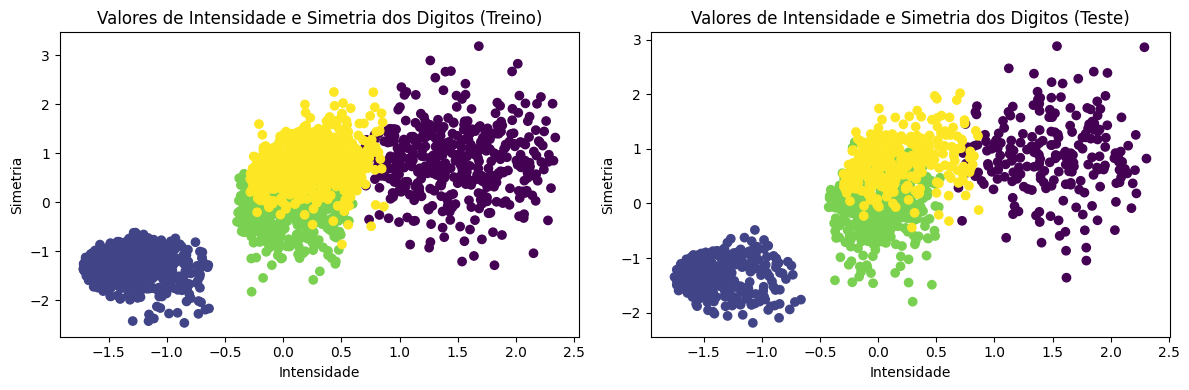

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

t_train = np.array(train_data)
ax[0].scatter(t_train[:, 1], t_train[:, 2], c=t_train[:, 0], cmap='viridis')
ax[0].set_xlabel('Intensidade')
ax[0].set_ylabel('Simetria')
ax[0].set_title('Valores de Intensidade e Simetria dos Digitos (Treino)')

t_test = np.array(test_data)
ax[1].scatter(t_test[:, 1], t_test[:, 2], c=t_test[:, 0], cmap='viridis')
ax[1].set_xlabel('Intensidade')
ax[1].set_ylabel('Simetria')
ax[1].set_title('Valores de Intensidade e Simetria dos Digitos (Teste)')

plt.tight_layout()
plt.show()

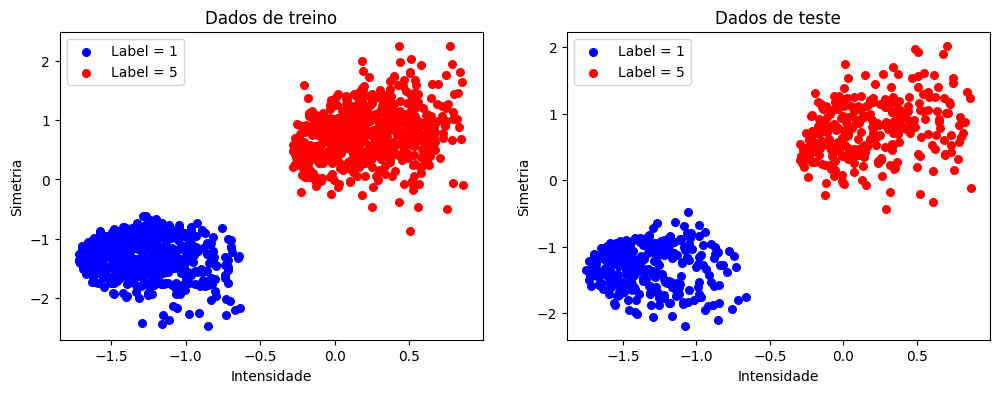

In [141]:
train1x5 = train_data[np.isin(train_data[:, 0], [1, 5])]
X_train = np.array(train1x5[:,1:])
y_train = np.array(train1x5[:,0])

test1x5 = test_data[np.isin(test_data[:, 0], [1, 5])]
X_test = np.array(test1x5[:,1:])
y_test = np.array(test1x5[:, 0])


# Plotando os dados com diferentes cores para y_train = 1 e y_train = 5
#dados treino
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', marker='o', s=30, label='Label = 1')
ax[0].scatter(X_train[y_train == 5, 0], X_train[y_train == 5, 1], color='red', marker='o', s=30, label='Label = 5')
ax[0].set_title("Dados de treino")
ax[0].set_xlabel("Intensidade")
ax[0].set_ylabel("Simetria")
ax[0].legend()
#dados teste
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='blue', marker='o', s=30, label='Label = 1')
ax[1].scatter(X_test[y_test == 5, 0], X_test[y_test == 5, 1], color='red', marker='o', s=30, label='Label = 5')
ax[1].set_title("Dados de teste")
ax[1].set_xlabel("Intensidade")
ax[1].set_ylabel("Simetria")
ax[1].legend()



# Exibindo o gráfico
plt.show()

# PERCEPTRON

In [142]:
def PLA(X, y, f, max_iter = 100):

    w = [0, 0, 0]
    it = 0 
    listaPCI = X
    new_y = y
    
    while (len(listaPCI) > 0) and it < max_iter:
        random_x = random.choice(listaPCI) 
        index = np.where(listaPCI == random_x)[0][0]
        xi = [1]  + listaPCI[index].tolist() #xi deve conter 3 elementos // o primeiro elemento é o bias
        yi = new_y[index]
        for i in range(0, len(w)):
            w[i] = w[i] + yi * xi[i]
        listaPCI, new_y = constroiListaPCI(X,y,w)
        it += 1
        
    return w
    
def constroiListaPCI(X, y, w):
    l = []
    new_y = []
 
    for i in range(0,len(X)):
        if (np.sign(w[0] + w[1]*X[i][0] + w[2]*X[i][1]) != y[i]):
            l.append(X[i])
            new_y.append(y[i])
    
    return l, new_y   


def predict(w, X):
    predito = []
    for x in X:
        for i in range(len(x)):
            ypred = w[0] + w[1]*x[0] + w[2]*x[1]
        predito.append(np.sign(ypred))
    return predito


In [143]:
y_train = np.where(y_train == 1, 1, np.where(y_train == 5, -1, y_train))
# Crie a funcao alvo e o dataset
p1 = list(np.random.uniform(-1, 1, 2))
p2 = list(np.random.uniform(-1, 1, 2))

# Coeficientes da função alvo
m = (p2[1]-p1[1])/(p2[0]-p1[0]) #coeficiente angular
b = p1[1] - m *p1[0] #coeficiente linear
f = [m,b]

w = PLA(X_train,y_train,f)

x_reta_PLA = [-2,2]
y_reta_PLA = construirReta(w, x_reta_PLA)
y_pred = np.array(predict(w, X_test))

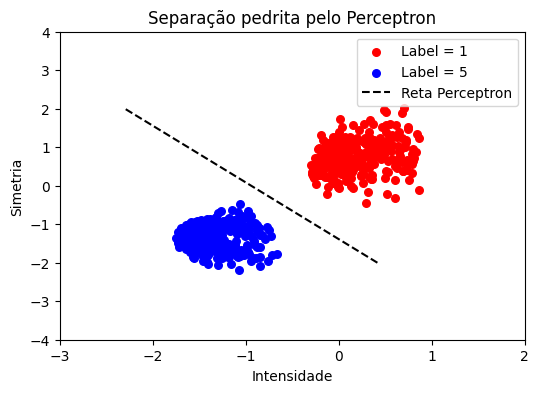

In [144]:
# Plotando os dados com diferentes cores para os valores do teste predito x real
#dados treino
y_test = np.where(y_test == 1, 1, np.where(y_test == 5, -1, y_test))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#dados teste
plt.axis([-3, 2, -4, 4])
plt.scatter(X_test[y_pred == -1, 0], X_test[y_pred == -1, 1], color='red', marker='o', s=30, label='Label = 1')
plt.scatter(X_test[y_pred == 1, 0], X_test[y_pred == 1, 1], color='blue', marker='o', s=30, label='Label = 5')
plt.plot(y_reta_PLA, x_reta_PLA, 'k--', label="Reta Perceptron")
plt.title("Separação pedrita pelo Perceptron")
plt.xlabel("Intensidade")
plt.ylabel("Simetria")
plt.legend()

# Exibindo o gráfico
plt.show()

In [145]:
modelo_metricas(y_test,y_pred)
print(f'PRECISÃO: {getPrecisao(y_test,y_pred)}')

#ALTA PRECISÃO = O MODELO COMETEU POUCOS FALSOS POSITIVOS  (P/P+FP)
#RECALL = O MODELO ACERTOU A MAIORIA DOS CASOS POSITIVOS (P/P+FN)
#F1 = MÉDIA HARMÔNICA ENTRE PRECISÃO E RECALL


-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       291
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

----------------------------------------------------------

PRECISÃO: 1.0


# REGRESSÃO LINEAR 

In [146]:
class LinearRegression:

    def fit(self, _X, _y):
        X = np.array(_X)  
        y = np.array(_y)
        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y  
    
    def predict(self, _x, w):
        X = np.array(_x)  
        prediction =  X @ w
        return np.where(prediction <= 0, -1, 1)

    def getW(self):
        return self.w


Text(0, 0.5, 'Simetria')

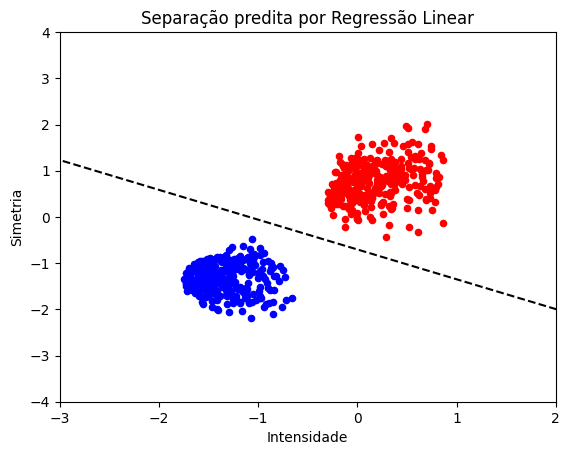

In [147]:
X_train = np.array([[1,x[0], x[1]] for x in  X_train])
y_train = np.array(y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)
weigths = lr.getW()


x_reta_LR = [-2, 2]
y_reta_LR = construirReta(weigths, x_reta_LR)

X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
y_pred_ll = np.array(lr.predict(X_test, weigths))

plt.axis([-3, 2, -4, 4])
plt.plot(y_reta_LR, x_reta_LR,  'k--', label="Reta Perceptron")
plt.scatter(X_test[y_pred_ll == -1, 1], X_test[y_pred_ll == -1, 2], color='red', marker='o', s=20, label='Label = 1')
plt.scatter(X_test[y_pred_ll == 1, 1], X_test[y_pred_ll == 1, 2], color='blue', marker='o', s=20, label='Label = -1')
plt.title("Separação predita por Regressão Linear")
plt.xlabel("Intensidade")
plt.ylabel("Simetria")


In [148]:
modelo_metricas(y_test,y_pred_ll)


-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       291
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

----------------------------------------------------------



# REGRESSÃO LOGISTICA

In [149]:
class LogisticRegression:

    def __init__(self, eta=0.1, tmax=1000, batch_size=64, lam=0):
        self.eta = eta
        self.tmax = tmax
        self.batch_size = batch_size
        self.lam = lam

    def fit(self,  X, y):
        self.w = []

        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        d = X.shape[1]
        N = X.shape[0]
        w = np.zeros(d, dtype=np.float64)

        for i in range(self.tmax):
            vsoma = np.zeros(d, dtype=np.float64)

            if self.batch_size < N:
                indices = random.sample(range(N),self.batch_size)
                batchX = [X[index] for index in indices]
                batchY = [y[index] for index in indices]
            else:
                batchX = X
                batchY = y

            # Gradiente
            for xn, yn in zip(batchX, batchY):
                vsoma += (yn * xn) / (1 + np.exp((yn * w).T @ xn))

            gt = vsoma/self.batch_size
            if self.lam != 0:
              gt += 2*self.lam * w

            if LA.norm(gt) < 0.0001 :
                break
            w = w + (self.eta*gt)

        self.w = w

    def predict_prob(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.array([1 / (1 + np.exp(-(np.dot(self.w, x)))) for x in X])
    
    def predict(self, X,w):

        resultado = np.dot(X, w)
        resultado = np.sign(resultado)
        return resultado

    def calcula_ein(self, w, X, y):
        y_pred = self.predict(w, X)
        return np.sum(y_pred != y)/len(y)

    def getW(self):
        return self.w




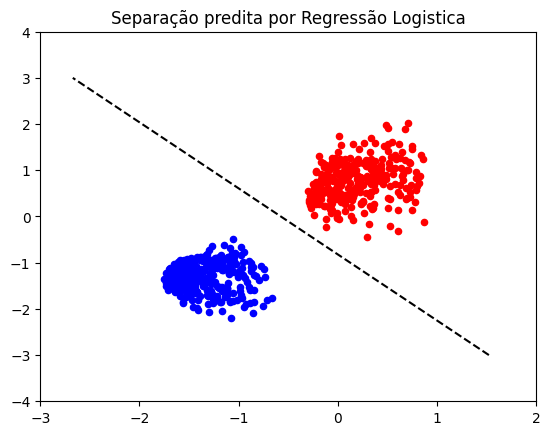

In [150]:
#Executando a regressão Logistica
logistic = LogisticRegression(0.1, 1000, 64)
logistic.fit(X_train, y_train)
weigths = logistic.getW()

# Plota as porcentagens da Regressão Logística
y_pred_rl = logistic.predict(X_test,weigths)

#Reta
x_reta_LOG = [-3, +3]
y_reta_LOG = construirReta(weigths, x_reta_LOG)

plt.axis([-3, 2, -4, 4])
plt.plot(y_reta_LOG, x_reta_LOG, 'k--', label='g(.)')
plt.scatter(X_test[y_pred_rl == -1, 1], X_test[y_pred_rl == -1, 2], color='red', marker='o', s=20)
plt.scatter(X_test[y_pred_rl == 1, 1], X_test[y_pred_rl == 1, 2], color='blue', marker='o', s=20)
plt.title("Separação predita por Regressão Logistica")
plt.show()


In [151]:
modelo_metricas(y_test,y_pred_rl)


-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       291
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

----------------------------------------------------------



# WEIGHT DECAY

In [152]:
class WeightDecay:
    # Infere o vetor w da função hipótese
    def fit(self, X, y, eta, ninteraction, batch):
        training_x, testing_x, training_y, testing_y = train_test_split(X, y, test_size=0.2, random_state=2698)

        # Adiciona a coluna de viés (1s) em training_x e testing_x
        training_x = np.hstack((np.ones((training_x.shape[0], 1)), training_x))
        testing_x = np.hstack((np.ones((testing_x.shape[0], 1)), testing_x))

        lambdas = sorted([10 ** x for x in range(-5, 5)])
        lambdas.append(0)
        bestEout = float('inf')

        for lam in lambdas:
            classifier = LogisticRegression(eta, ninteraction, batch, lam)
            try:
                classifier.fit(training_x, training_y)
                weight = classifier.getW()
            except RuntimeWarning:
                continue

            # Computando o erro quadrático (Eout)
            eOut = self.getEout(classifier.predict(testing_x, weight), testing_y)

            if eOut < bestEout:
                bestEout = eOut
                self.classifier = classifier

        self.w = self.classifier.w
        return self.w

    # Retorna as probabilidades da classe positiva
    def predict_prob(self, X, weight):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.array([1 / (1 + np.exp(-(np.dot(x, weight)))) for x in X])

    # Predição por classificação linear (limiar 0.5)
    def predict(self, X, weight):
        return np.array([1 if prob >= 0.5 else -1 for prob in self.predict_prob(X,weight)])

    # Calcula erro Eout
    def getEout(self, predicted_y_test, testing_y):
        return np.mean(predicted_y_test != testing_y)

    def getW(self):
        return self.w



In [153]:
eta = 0.01
ninteraction = 1000
batch = 64
wd = WeightDecay()
weight_d = wd.fit(X_train, y_train, eta, ninteraction,  batch)  # Treina o modelo antes de usar predict
# Agora podemos chamar getW() e predict()
y_pred_wdecay = wd.predict(X_test,weight_d)
modelo_metricas(y_test, y_pred_wdecay)


-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       291
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

----------------------------------------------------------



# COMPARANDO AS 3 RETAS



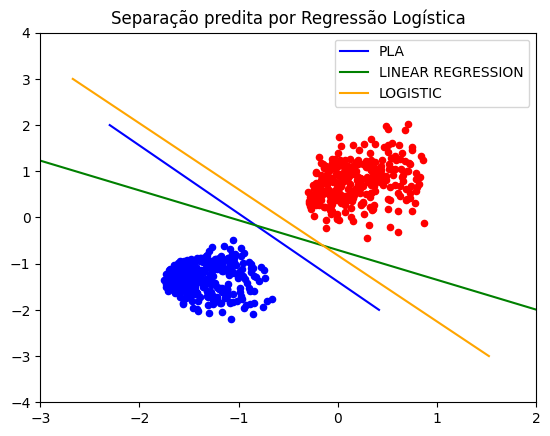

In [154]:
plt.axis([-3, 2, -4, 4])

plt.plot(y_reta_PLA, x_reta_PLA, color='blue', label='PLA')
plt.plot(y_reta_LR, x_reta_LR, color='green', label='LINEAR REGRESSION')
plt.plot(y_reta_LOG, x_reta_LOG, color='orange', label='LOGISTIC')

plt.scatter(X_test[y_pred == -1, 1], X_test[y_pred == -1, 2], color='red', marker='o', s=20)
plt.scatter(X_test[y_pred == 1, 1], X_test[y_pred == 1, 2], color='blue', marker='o', s=20)

plt.title("Separação predita por Regressão Logística")
plt.legend()  # Adiciona a legenda para identificar as retas
plt.show()



# **CLASSIFICADOR COMPLETO**

### **UM CONTRA TODOS**

### Tenho 24 combinações possíveis (4!), e para cada modelo 3 funções, logo teremos 72 rodagens para cada modelo!

#### **SEPARANDO O DADO DO DIGITO ESCOLHIDO:**

In [155]:
def choose_digit_vs_others(traindata, testdata, digit):
    
    
    y_train = np.where(traindata[:,0] == digit, 1, -1)
    X_train = np.array(traindata[:, 1:])

    y_test = np.where(testdata[:,0] == digit, 1, -1)
    X_test = np.array(testdata[:, 1:])


    #new_classes = np.unique(y_train)
    #print("Valores", digit, "--> ",new_classes[0] ,"|| Valores de contraste",np.unique(train_data.loc[~train_data['label'].isin([digit]), 'label']),"--> ", new_classes[0])
    # print(np.unique(y_train))
    return X_train, y_train, X_test, y_test



### **CALCULANDO TODOS OS PESOS:**
PROCEDIMENTO ABAIXO:
1) PARA CADA PERMUTAÇÃO (24), CALCULAMOS AS 3 FUNÇÕES.
2) AS 3 FUNÇÕES DE CADA PERMUTAÇÃO SÃO JOGADAS NA PREDIÇÃO MULTICLASSE
3) CALCULAMOS ACURACIA DO MODELO MULTICLASSE PARA CADA UMA DAS 24 PERMUTAÇÕES.
       --> A MELHOR ACURACIA DAS 24 É A QUE MELHOR CLASSIFICA. COMO TEMOS A LISTA DAS POSSIVEIS PERMUTAÇÕES, SABEREMOS QUAL A ORDEM QUE
           MELHOR CLASSIFICA.


##### **1) PARA CADA PERMUTAÇÃO (24), CALCULAMOS AS 3 FUNÇÕES:**

##### **2) AS 3 FUNÇÕES DE CADA PERMUTAÇÃO SÃO JOGADAS NA PREDIÇÃO MULTICLASSE:**

In [156]:
valores = (0, 1, 4, 5)
todas_permutacoes = list(permutations(valores))  # Todas as permutações possíveis

rodagensPLA = []
rodagensRL  = []
rodagensLOG = []

#reta pla
p1 = list(np.random.uniform(-1, 1, 2))
p2 = list(np.random.uniform(-1, 1, 2))

# Coeficientes da função alvo
m = (p2[1]-p1[1])/(p2[0]-p1[0]) #coeficiente angular
b = p1[1] - m *p1[0] #coeficiente linear
f = [m,b]

     
#parametros para o weigth decay - brincar com eles
eta = 0.1 #para rodar mais rápido, deixar maior MAS piora a classificação
ninteraction = 1000#para rodar mais rápido, deixar menor MAS piora a classificação
batch = 64

YPRED_PLA = []
YPRED_LR  = []
YPRED_LOG = []

retas_PLA = []
retas_LR = []
retas_LOG = []

x_reta = [-2,3]

for i in range(len(todas_permutacoes)):
    # ypredPLA_test = test_data[:, 0].copy()
    # ypredLR_test = test_data[:, 0].copy()
    # ypredLOG_test = test_data[:, 0].copy()
    ypredPLA_test = np.full_like(test_data[:, 0], 0)
    ypredLR_test = np.full_like(test_data[:, 0], 0)
    ypredLOG_test = np.full_like(test_data[:, 0], 0)
    
    perm = todas_permutacoes[i] #escolhendo a combinação
    contraste1 = perm[0]
    contraste2 = perm[1]
    contraste3 = perm[2]
    
    #f0 ===================================================================================================
    Xtrain, ytrain, Xtest, ytest = choose_digit_vs_others(train_data, test_data, contraste1)
    
    #PLA
    w_f0_PLA = PLA(Xtrain,ytrain,f)
    ypredpla = np.array(predict(w_f0_PLA, Xtest))
    ypredPLA_test = np.where(ypredpla == 1, contraste1, ypredPLA_test)
    
    
    #LINEAR REGRESSION
    X = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))
    lr = LinearRegression()
    lr.fit(np.hstack((np.ones((Xtrain.shape[0], 1)), Xtrain)), ytrain)
    w_f0_RL = lr.getW()
    ypredlr = lr.predict(X, w_f0_RL)
    ypredLR_test = np.where(ypredlr == 1, contraste1, ypredLR_test)
    
    
    #LOGISTIC - WEIGTH DECAY
    wd = WeightDecay()
    wd.fit(Xtrain, ytrain, eta, ninteraction, batch)
    w_f0_LOG = wd.getW()
    ypredlog = wd.predict(Xtest, w_f0_LOG)
    ypredLOG_test = np.where(ypredlog == 1, contraste1, ypredLOG_test)

    
    # f1 ====================================================================================================
    mask_f1 = ~np.isin(train_data[:, 0], [contraste1])
    train_three_labels = train_data[mask_f1].copy()
    mask_test_f1 = ~np.isin(test_data[:, 0], [contraste1])
    test_three_labels = test_data[mask_test_f1].copy()

    Xtrain, ytrain, Xtest, ytest = choose_digit_vs_others(train_three_labels, test_three_labels,contraste2)

    # PLA
    w_f1_PLA = PLA(Xtrain, ytrain, f)
    ypredpla = np.array(predict(w_f1_PLA, Xtest))
    ypredPLA_test[mask_test_f1] = np.where(ypredpla == 1, contraste2, ypredPLA_test[mask_test_f1])
    
    
    # LINEAR REGRESSION
    X = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))
    lr = LinearRegression()
    lr.fit(np.hstack((np.ones((Xtrain.shape[0], 1)), Xtrain)), ytrain)
    w_f1_RL = lr.getW()
    ypredlr = lr.predict(X, w_f1_RL)
    ypredLR_test[mask_test_f1] = np.where(ypredlr == 1, contraste2, ypredLR_test[mask_test_f1])
    
    # LOGISTIC - WEIGHT DECAY
    wd = WeightDecay()
    wd.fit(Xtrain, ytrain, eta, ninteraction, batch)
    w_f1_LOG = wd.getW()
    ypredlog = wd.predict(Xtest, w_f1_LOG)
    ypredLOG_test[mask_test_f1] = np.where(ypredlog == 1, contraste2, ypredLOG_test[mask_test_f1])
    
    #f2 ==================================================================================================
    
    mask_f2 = ~np.isin(train_data[:, 0], [contraste1, contraste2])
    train_two_labels = train_data[mask_f2].copy()
    mask_test_f2 = ~np.isin(test_data[:, 0], [contraste1, contraste2])
    test_two_labels = test_data[mask_test_f2].copy()
    
    Xtrain, ytrain, Xtest, ytest = choose_digit_vs_others(train_two_labels, test_two_labels, contraste3)
         
    # PLA
    w_f2_PLA = PLA(Xtrain, ytrain, f)
    ypredpla = np.array(predict(w_f2_PLA, Xtest))
    ypredPLA_test[mask_test_f2] = np.where(ypredpla == 1, contraste3, ypredPLA_test[mask_test_f2])
    
    
    #LINEAR REGRESSION
    X = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))
    lr = LinearRegression()
    lr.fit(np.hstack((np.ones((Xtrain.shape[0], 1)), Xtrain)), ytrain)
    w_f2_RL = lr.getW()
    ypredlr = lr.predict(X, w_f2_RL)
    ypredLR_test[mask_test_f2] = np.where(ypredlr == 1, contraste3, ypredLR_test[mask_test_f2])

    #LOGISTIC - WEIGTH DECAY
    wd = WeightDecay()
    wd.fit(Xtrain, ytrain, eta, ninteraction, batch)
    w_f2_LOG = wd.getW()
    ypredlog = wd.predict(Xtest, w_f2_LOG)
    ypredLOG_test[mask_test_f2] = np.where(ypredlog == 1, contraste3, ypredLOG_test[mask_test_f2])

    #armazenando as retas

    reta_f0_PLA = construirReta(w_f0_PLA, x_reta)
    reta_f0_LR = construirReta(w_f0_RL, x_reta)
    reta_f0_LOG = construirReta(w_f0_LOG, x_reta)
    
    reta_f1_PLA = construirReta(w_f1_PLA, x_reta)
    reta_f1_LR = construirReta(w_f1_RL, x_reta)
    reta_f1_LOG = construirReta(w_f1_LOG, x_reta)
    
    reta_f2_PLA = construirReta(w_f2_PLA, x_reta)
    reta_f2_LR = construirReta(w_f2_RL, x_reta)
    reta_f2_LOG = construirReta(w_f2_LOG, x_reta)
    
    # Armazenando as retas em listas
    retas_PLA.append([reta_f0_PLA, reta_f1_PLA, reta_f2_PLA])
    retas_LR.append([reta_f0_LR, reta_f1_LR, reta_f2_LR])
    retas_LOG.append([reta_f0_LOG, reta_f1_LOG, reta_f2_LOG])
        

    YPRED_PLA.append(ypredPLA_test)
    YPRED_LR.append(ypredLR_test)
    YPRED_LOG.append(ypredLOG_test)

##### **3) CALCULAMOS ACURACIA DO MODELO MULTICLASSE PARA CADA UMA DAS 24 PERMUTAÇÕES:**

In [157]:
# CALCULANDO AS MÉTRICAS PRA OS MODELOS
X_TESTE = np.array(test_data[:, 1:3])  
Y_TESTE = test_data[:, 0]
acuraciasPLA = []
acuraciasRL = []
acuraciasLOG = []
melhor_acuraciaPLA = 0
melhor_acuraciaRL = 0
melhor_acuraciaLOG = 0
indice_melhor_acuraciaPLA = -1
indice_melhor_acuraciaRL = -1
indice_melhor_acuraciaLOG = -1

#PLA
for i in range(len(todas_permutacoes)):
    reportPLA = classification_report(Y_TESTE, YPRED_PLA[i], output_dict=True, zero_division=1)
    reportLR = classification_report(Y_TESTE, YPRED_LR[i], output_dict=True, zero_division=1)
    reportLOG= classification_report(Y_TESTE, YPRED_LOG[i], output_dict=True, zero_division=1)
    acuraciaPLA = reportPLA['accuracy']  
    acuraciaRL = reportLR['accuracy']  
    acuraciaLOG = reportLOG['accuracy']
    acuraciasPLA.append(acuraciaPLA)
    acuraciasRL.append(acuraciaRL)
    acuraciasLOG.append(acuraciaLOG)

    if acuraciaPLA > melhor_acuraciaPLA:
        melhor_acuraciaPLA = acuraciaPLA
        indice_melhor_acuraciaPLA = i

    if acuraciaRL > melhor_acuraciaRL:
        melhor_acuraciaRL = acuraciaRL
        indice_melhor_acuraciaRL = i

    if acuraciaLOG > melhor_acuraciaLOG:
        melhor_acuraciaLOG = acuraciaLOG
        indice_melhor_acuraciaLOG = i

print("\n=======================> MODELO DE MELHOR ACURACIA PELO PLA <===================================")
print(f" Ordem: {todas_permutacoes[indice_melhor_acuraciaPLA]}: ")
print(f"                    Acurácia = {melhor_acuraciaPLA}")
print(classification_report(Y_TESTE, YPRED_PLA[indice_melhor_acuraciaPLA], zero_division=1))

print("\n==================> MODELO DE MELHOR ACURACIA PELA REGRESSÃO LINEAR <===========================")
print(f" Ordem: {todas_permutacoes[indice_melhor_acuraciaRL]}: ")
print(f"                    Acurácia = {melhor_acuraciaRL}")
print(classification_report(Y_TESTE, YPRED_LR[indice_melhor_acuraciaRL], zero_division=1))


print("\n==================> MODELO DE MELHOR ACURACIA PELA LOGISTICA COM WEIGHT DECAY <===========================")
print(f" Ordem: {todas_permutacoes[indice_melhor_acuraciaLOG]}: ")
print(f"                    Acurácia = {melhor_acuraciaLOG}")
print(classification_report(Y_TESTE, YPRED_LOG[indice_melhor_acuraciaLOG], zero_division=1))



=======================> MODELO DE MELHOR ACURACIA PELO PLA <===================================
 Ordem: (1, 5, 4, 0): 
                    Acurácia = 0.8663677130044843
              precision    recall  f1-score   support

         0.0       0.84      0.39      0.53       218
         1.0       1.00      1.00      1.00       292
         4.0       1.00      1.00      1.00       314
         5.0       0.67      0.95      0.79       291

    accuracy                           0.87      1115
   macro avg       0.88      0.83      0.83      1115
weighted avg       0.88      0.87      0.85      1115


==================> MODELO DE MELHOR ACURACIA PELA REGRESSÃO LINEAR <===========================
 Ordem: (1, 4, 5, 0): 
                    Acurácia = 0.9363228699551569
              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85       218
         1.0       1.00      1.00      1.00       292
         4.0       0.98      0.84      0.90       314
      

## **PLOTANDO OS MELHORES MODELOS**

#### Vou ver primeiro quantos grupos foram conseguidos:

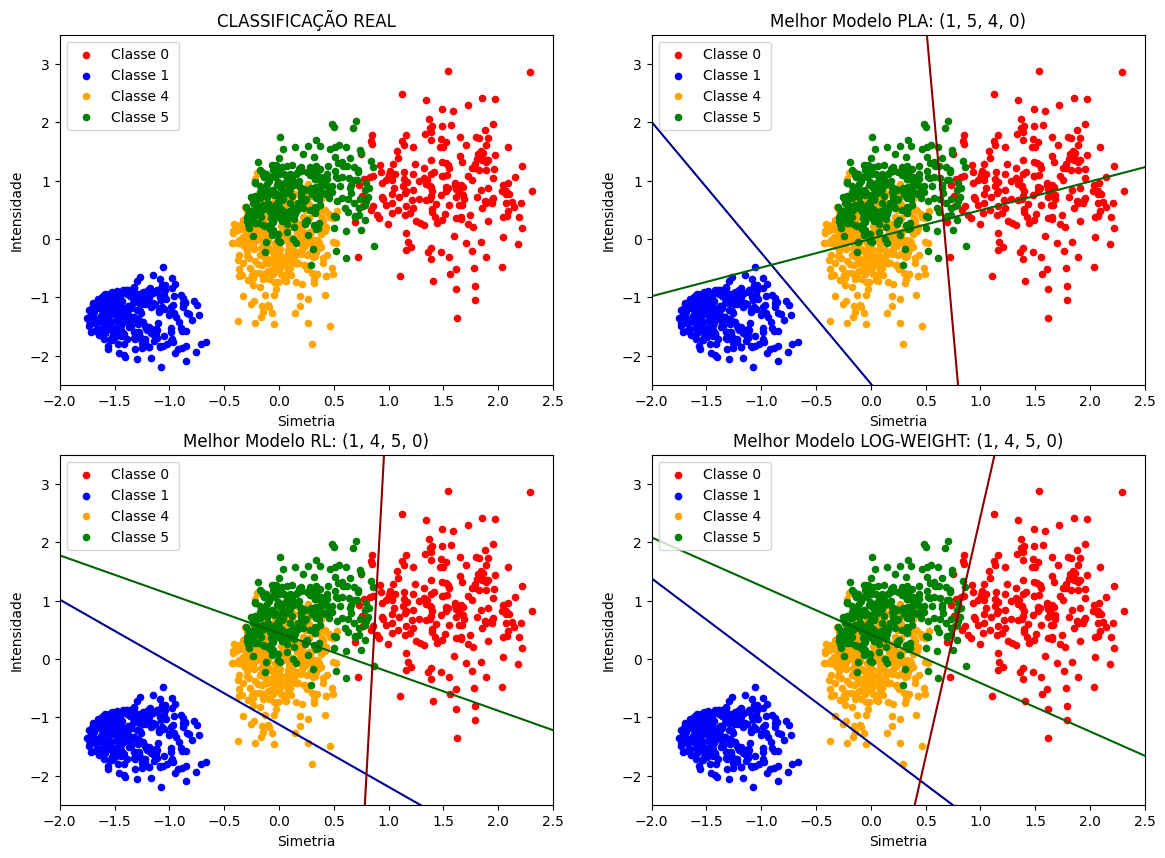

In [162]:
import matplotlib.pyplot as plt
import numpy as np

# Para o PLA
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# CLASSIFICAÇÃO REAL


ax[0,0].scatter(X_TESTE[Y_TESTE == 0, 0], X_TESTE[Y_TESTE == 0, 1], color='red', marker='o', s=20, label="Classe 0")
ax[0,0].scatter(X_TESTE[Y_TESTE == 1, 0], X_TESTE[Y_TESTE == 1, 1], color='blue', marker='o', s=20, label="Classe 1 ")
ax[0,0].scatter(X_TESTE[Y_TESTE == 4, 0], X_TESTE[Y_TESTE == 4, 1], color='orange', marker='o', s=20, label="Classe 4")
ax[0,0].scatter(X_TESTE[Y_TESTE == 5, 0], X_TESTE[Y_TESTE == 5, 1], color='green', marker='o', s=20, label="Classe 5")
ax[0,0].set_ylim(-2.5, 3.5)
ax[0,0].set_xlim(-2, 2.5)
ax[0,0].set_title(f"CLASSIFICAÇÃO REAL")
ax[0,0].set_xlabel("Simetria")
ax[0,0].set_ylabel("Intensidade")
ax[0,0].legend(loc='best')

vals = np.unique(YPRED_PLA[indice_melhor_acuraciaPLA])
ax[0,1].scatter(X_TESTE[Y_TESTE == 0, 0], X_TESTE[Y_TESTE == 0, 1], color='red', marker='o', s=20, label="Classe 0")
ax[0,1].scatter(X_TESTE[Y_TESTE == 1, 0], X_TESTE[Y_TESTE == 1, 1], color='blue', marker='o', s=20, label="Classe 1 ")
ax[0,1].scatter(X_TESTE[Y_TESTE == 4, 0], X_TESTE[Y_TESTE == 4, 1], color='orange', marker='o', s=20, label="Classe 4")
ax[0,1].scatter(X_TESTE[Y_TESTE == 5, 0], X_TESTE[Y_TESTE == 5, 1], color='green', marker='o', s=20, label="Classe 5")

reta1 = retas_PLA[indice_melhor_acuraciaPLA][0]
reta2 = retas_PLA[indice_melhor_acuraciaPLA][1]
reta3 = retas_PLA[indice_melhor_acuraciaPLA][2]
ax[0,1].plot( x_reta, reta1, color='darkblue')
ax[0,1].plot(x_reta, reta2, color='darkgreen')
ax[0,1].plot(x_reta, reta3, color='darkred')

ax[0,1].set_title(f"Melhor Modelo PLA: {todas_permutacoes[indice_melhor_acuraciaPLA]}")
ax[0,1].set_ylim(-2.5, 3.5)
ax[0,1].set_xlim(-2, 2.5)
ax[0,1].set_xlabel("Simetria")
ax[0,1].set_ylabel("Intensidade")
ax[0,1].legend(loc='best')

# Para Regressão Linear
vals = np.unique(YPRED_LR[indice_melhor_acuraciaRL])
ax[1,0].scatter(X_TESTE[Y_TESTE == 0, 0], X_TESTE[Y_TESTE == 0, 1], color='red', marker='o', s=20, label="Classe 0")
ax[1,0].scatter(X_TESTE[Y_TESTE == 1, 0], X_TESTE[Y_TESTE == 1, 1], color='blue', marker='o', s=20, label="Classe 1 ")
ax[1,0].scatter(X_TESTE[Y_TESTE == 4, 0], X_TESTE[Y_TESTE == 4, 1], color='orange', marker='o', s=20, label="Classe 4")
ax[1,0].scatter(X_TESTE[Y_TESTE == 5, 0], X_TESTE[Y_TESTE == 5, 1], color='green', marker='o', s=20, label="Classe 5")

ax[1,0].set_title(f"Melhor Modelo RL: {todas_permutacoes[indice_melhor_acuraciaRL]}")
ax[1,0].set_ylim(-2.5, 3.5)
ax[1,0].set_xlim(-2, 2.5)
ax[1,0].set_xlabel("Simetria")
ax[1,0].set_ylabel("Intensidade")
ax[1,0].legend(loc='best')

reta1 = retas_LR[indice_melhor_acuraciaRL][0]
reta2 = retas_LR[indice_melhor_acuraciaRL][1]
reta3 = retas_LR[indice_melhor_acuraciaRL][2]
ax[1,0].plot(x_reta, reta1, color='darkblue')
ax[1,0].plot(x_reta, reta2, color='darkgreen')
ax[1,0].plot(x_reta, reta3, color='darkred')

# Para Regressão Logistica com Weight decay
vals = np.unique(YPRED_LOG[indice_melhor_acuraciaLOG])
ax[1,1].scatter(X_TESTE[Y_TESTE == 0, 0], X_TESTE[Y_TESTE == 0, 1], color='red', marker='o', s=20, label="Classe 0")
ax[1,1].scatter(X_TESTE[Y_TESTE == 1, 0], X_TESTE[Y_TESTE == 1, 1], color='blue', marker='o', s=20, label="Classe 1 ")
ax[1,1].scatter(X_TESTE[Y_TESTE == 4, 0], X_TESTE[Y_TESTE == 4, 1], color='orange', marker='o', s=20, label="Classe 4")
ax[1,1].scatter(X_TESTE[Y_TESTE == 5, 0], X_TESTE[Y_TESTE == 5, 1], color='green', marker='o', s=20, label="Classe 5")

ax[1,1].set_title(f"Melhor Modelo LOG-WEIGHT: {todas_permutacoes[indice_melhor_acuraciaLOG]}")
ax[1,1].set_ylim(-2.5, 3.5)
ax[1,1].set_xlim(-2, 2.5)
ax[1,1].set_xlabel("Simetria")
ax[1,1].set_ylabel("Intensidade")
ax[1,1].legend(loc='best')


reta1 = retas_LOG[indice_melhor_acuraciaLOG][0]
reta2 = retas_LOG[indice_melhor_acuraciaLOG][1]
reta3 = retas_LOG[indice_melhor_acuraciaLOG][2]
ax[1,1].plot(x_reta, reta1, color='darkblue')
ax[1,1].plot(x_reta, reta2, color='darkgreen')
ax[1,1].plot(x_reta, reta3, color='darkred')



plt.show()
